Oil Production Forecast with LSTM
-------------------------------------------------------

### Import required libraries

In [ ]:
# Let's import the libraries required for the image classification
import os
import glob
RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import tensorflow as tf
tf.random.set_seed(RAND_SEED)
import random
random.seed(RAND_SEED)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Import and visualize Oil production data

Downloading...
From:  https://drive.google.com/uc?id=17h-XYKKLXeZq-teu0I_UwHj-HkwE6X33
To: /content/Volve_Oil_Production.csv
100%|██████████| 243k/243k [00:00<00:00, 40.7MB/s]


<Axes: title={'center': 'Cum. Oil Production'}, xlabel='DAY_OF_PROD'>

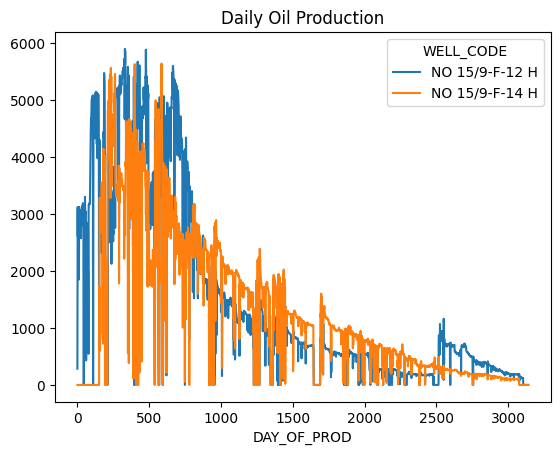

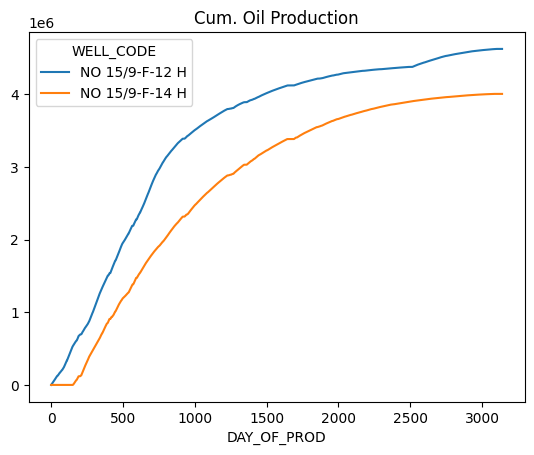

In [ ]:

import gdown

url = ' https://drive.google.com/uc?id=17h-XYKKLXeZq-teu0I_UwHj-HkwE6X33'
InputDataFile = 'Volve_Oil_Production.csv'
gdown.download(url, InputDataFile, quiet=False)

df = pd.read_csv(InputDataFile)
well_codes = df.WELL_CODE.unique()
df = df.pivot(index='DAY_OF_PROD', columns='WELL_CODE', values=['OIL_PROD_VOL', 'CUM_OIL_PROD'])
df.plot(y='OIL_PROD_VOL', title='Daily Oil Production')
df.plot(y='CUM_OIL_PROD', title='Cum. Oil Production')

### Create input data for LSTM training and testing

In [ ]:
train_oil_prod = df['CUM_OIL_PROD', well_codes[0]].values
test_oil_prod = df['CUM_OIL_PROD', well_codes[1]].values
LOOKBACK = 14

def prepare_lstm_input(prod_data, lookback, scaler=None):
    data = np.array(prod_data).reshape(-1, 1)
    if scaler == None:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    X = []
    y = []
    num_idxs = len(data)
    for i in range(lookback, num_idxs):
        i_start = i - lookback
        i_end = i - 1
        X.append([data[i] for i in range(i_start, i_end + 1)])
        y.append(data[i])
    num_y = len(y)
    X = np.array(X).reshape(num_y, lookback, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y, scaler

X_train, y_train, scaler = prepare_lstm_input(train_oil_prod, LOOKBACK)
X_test, y_test, _ = prepare_lstm_input(test_oil_prod, LOOKBACK, scaler)

### Build and train LSTM model

In [13]:
NUM_HIDDEN = 28
VALID_FRAC = 0.1
BATCH_SIZE = 32
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(LOOKBACK, 1)))
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=False))
model.add(Dense(NUM_HIDDEN))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss="mse")
# Early-stopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001,
    patience=50)
# Save the best model
ckpt_path = './models/lstm.h5'
ckpt_callback = ModelCheckpoint(filepath=ckpt_path, mode='min',
                                monitor='val_loss', verbose=1,
                                save_best_only=True)
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE,
                    validation_split=VALID_FRAC,
                    callbacks=[earlystop_callback, ckpt_callback],
                    verbose=1)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5403
Epoch 1: val_loss improved from inf to 0.87420, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.5403 - val_loss: 0.8742
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5355
Epoch 2: val_loss improved from 0.87420 to 0.86675, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5355 - val_loss: 0.8668
Epoch 3/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5304
Epoch 3: val_loss improved from 0.86675 to 0.85892, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5305 - val_loss: 0.8589
Epoch 4/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5252
Epoch 4: val_loss improved from 0.85892 to 0.85066, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5253 - val_loss: 0.8507
Epoch 5/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5197
Epoch 5: val_loss improved from 0.85066 to 0.84197, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5198 - val_loss: 0.8420
Epoch 6/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5140
Epoch 6: val_loss improved from 0.84197 to 0.83286, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5140 - val_loss: 0.8329
Epoch 7/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5080
Epoch 7: val_loss improved from 0.83286 to 0.82334, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5080 - val_loss: 0.8233
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5017
Epoch 8: val_loss improved from 0.82334 to 0.81343, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5017 - val_loss: 0.8134
Epoch 9/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4952
Epoch 9: val_loss improved from 0.81343 to 0.80315, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4952 - val_loss: 0.8032
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4885
Epoch 10: val_loss improved from 0.80315 to 0.79250, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4885 - val_loss: 0.7925
Epoch 11/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4814
Epoch 11: val_loss improved from 0.79250 to 0.78144, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4815 - val_loss: 0.7814
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4729
Epoch 12: val_loss improved from 0.78144 to 0.75681, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4729 - val_loss: 0.7568
Epoch 13/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4545
Epoch 13: val_loss improved from 0.75681 to 0.72724, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4544 - val_loss: 0.7272
Epoch 14/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4349
Epoch 14: val_loss improved from 0.72724 to 0.69704, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4348 - val_loss: 0.6970
Epoch 15/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4148
Epoch 15: val_loss improved from 0.69704 to 0.66519, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4147 - val_loss: 0.6652
Epoch 16/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3934
Epoch 16: val_loss improved from 0.66519 to 0.63083, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3934 - val_loss: 0.6308
Epoch 17/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3706
Epoch 17: val_loss improved from 0.63083 to 0.59127, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3704 - val_loss: 0.5913
Epoch 18/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3427
Epoch 18: val_loss improved from 0.59127 to 0.54012, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3426 - val_loss: 0.5401
Epoch 19/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3097
Epoch 19: val_loss improved from 0.54012 to 0.48448, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3094 - val_loss: 0.4845
Epoch 20/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2736
Epoch 20: val_loss improved from 0.48448 to 0.42403, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2735 - val_loss: 0.4240
Epoch 21/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2357
Epoch 21: val_loss improved from 0.42403 to 0.35979, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2353 - val_loss: 0.3598
Epoch 22/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1958
Epoch 22: val_loss improved from 0.35979 to 0.29343, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1955 - val_loss: 0.2934
Epoch 23/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1561
Epoch 23: val_loss improved from 0.29343 to 0.22810, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1558 - val_loss: 0.2281
Epoch 24/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1182
Epoch 24: val_loss improved from 0.22810 to 0.16700, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1180 - val_loss: 0.1670
Epoch 25/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0843
Epoch 25: val_loss improved from 0.16700 to 0.11404, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0841 - val_loss: 0.1140
Epoch 26/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0569
Epoch 26: val_loss improved from 0.11404 to 0.07266, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0567 - val_loss: 0.0727
Epoch 27/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0370
Epoch 27: val_loss improved from 0.07266 to 0.04349, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0368 - val_loss: 0.0435
Epoch 28/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0243
Epoch 28: val_loss improved from 0.04349 to 0.02520, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0243 - val_loss: 0.0252
Epoch 29/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0174
Epoch 29: val_loss improved from 0.02520 to 0.01481, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0174 - val_loss: 0.0148
Epoch 30/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141
Epoch 30: val_loss improved from 0.01481 to 0.00925, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0141 - val_loss: 0.0093
Epoch 31/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127
Epoch 31: val_loss improved from 0.00925 to 0.00633, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0126 - val_loss: 0.0063
Epoch 32/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120
Epoch 32: val_loss improved from 0.00633 to 0.00476, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0120 - val_loss: 0.0048
Epoch 33/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0116
Epoch 33: val_loss improved from 0.00476 to 0.00387, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 34/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0113
Epoch 34: val_loss improved from 0.00387 to 0.00332, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0113 - val_loss: 0.0033
Epoch 35/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111
Epoch 35: val_loss improved from 0.00332 to 0.00295, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 36/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109
Epoch 36: val_loss improved from 0.00295 to 0.00268, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0109 - val_loss: 0.0027
Epoch 37/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107
Epoch 37: val_loss improved from 0.00268 to 0.00248, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0107 - val_loss: 0.0025
Epoch 38/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0105
Epoch 38: val_loss improved from 0.00248 to 0.00232, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 39/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103
Epoch 39: val_loss improved from 0.00232 to 0.00218, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0103 - val_loss: 0.0022
Epoch 40/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0102
Epoch 40: val_loss improved from 0.00218 to 0.00207, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - val_loss: 0.0021
Epoch 41/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0100
Epoch 41: val_loss improved from 0.00207 to 0.00196, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0100 - val_loss: 0.0020
Epoch 42/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0099
Epoch 42: val_loss improved from 0.00196 to 0.00187, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0098 - val_loss: 0.0019
Epoch 43/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097
Epoch 43: val_loss improved from 0.00187 to 0.00179, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0097 - val_loss: 0.0018
Epoch 44/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095
Epoch 44: val_loss improved from 0.00179 to 0.00171, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0095 - val_loss: 0.0017
Epoch 45/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094
Epoch 45: val_loss improved from 0.00171 to 0.00164, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 46/50
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0093
Epoch 46: val_loss improved from 0.00164 to 0.00157, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0092 - val_loss: 0.0016
Epoch 47/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091
Epoch 47: val_loss improved from 0.00157 to 0.00151, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0091 - val_loss: 0.0015
Epoch 48/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0090
Epoch 48: val_loss improved from 0.00151 to 0.00145, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0090 - val_loss: 0.0015
Epoch 49/50
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088
Epoch 49: val_loss improved from 0.00145 to 0.00140, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0088 - val_loss: 0.0014
Epoch 50/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087
Epoch 50: val_loss improved from 0.00140 to 0.00134, saving model to ./models/lstm.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0087 - val_loss: 0.0013


### Review the model training

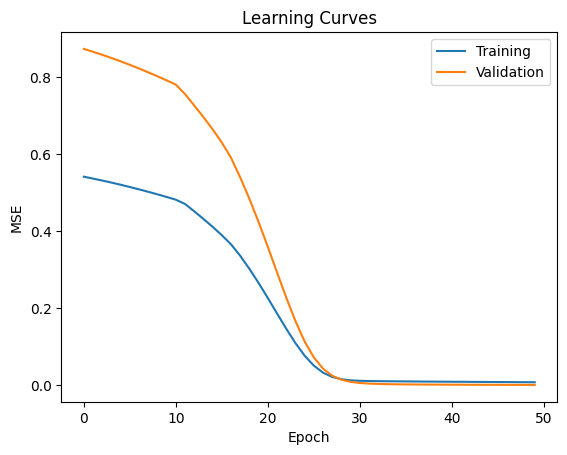

In [14]:
# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

### Use saved model to predict test data

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Text(0, 0.5, 'Predicted')

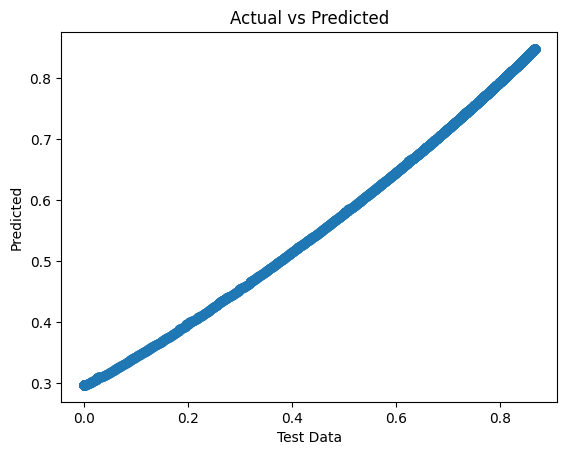

In [15]:
# Make predictions with the best model using test data
model = load_model(ckpt_path,custom_objects={'mse': 'mean_squared_error'})
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title('Actual vs Predicted')
plt.xlabel('Test Data')
plt.ylabel('Predicted')

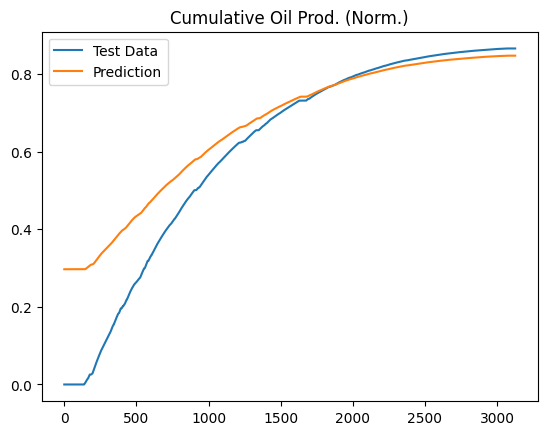

In [16]:
plt.title('Cumulative Oil Prod. (Norm.)')
plt.plot(y_test, label='Test Data')
plt.plot(y_pred, label='Prediction')
plt.legend(loc="best")

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


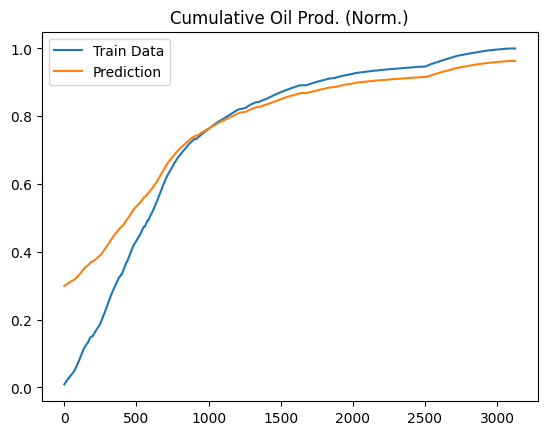

In [17]:
y_pred_train = model.predict(X_train)
plt.title('Cumulative Oil Prod. (Norm.)')
plt.plot(y_train, label='Train Data')
plt.plot(y_pred_train, label='Prediction')
plt.legend(loc="best")